# <span style='color:#bb26ed; font-weight:600;'>Movie Review Sentiment Analysis </span>

## <span style='color:#bb26ed; font-weight:600;'>Problem Statement </span>

#####  The goal of the project is to develop a machine learning model that uses nlp methods to automatically categorize movie reviews into  two sentiment categories: positive and negative.The intention is to make it possible to analyze public opinion in real time and to help assess how audiences respond to movies.

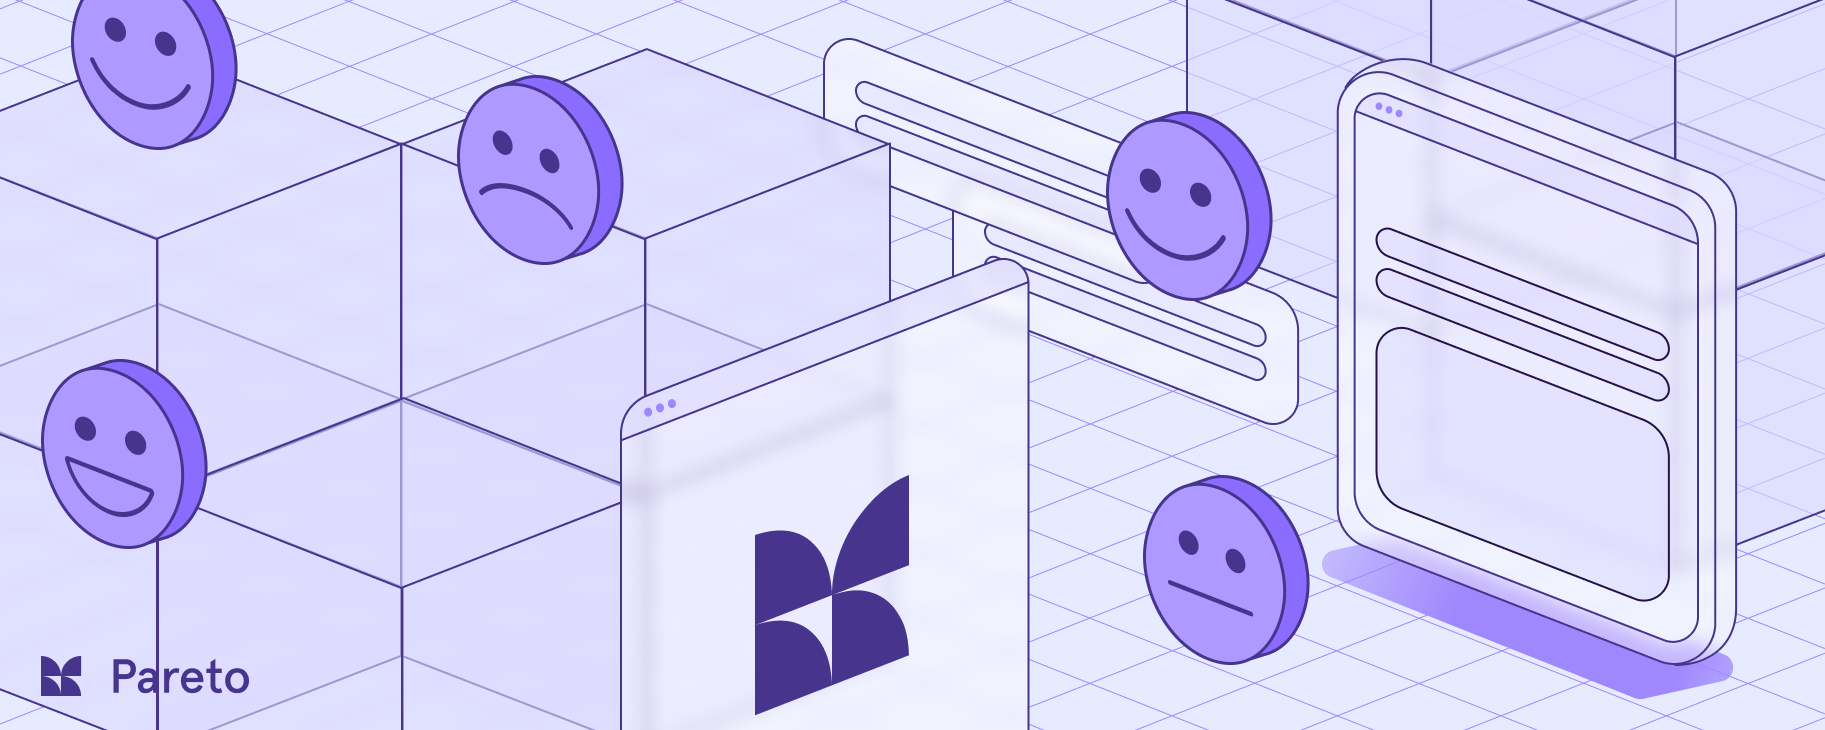

In [1]:
# importing necessary libraries
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import string
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import nltk
from wordcloud import WordCloud
from textblob import TextBlob

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import pickle

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to C:\Users\Arfa
[nltk_data]     Ahsan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Arfa
[nltk_data]     Ahsan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Arfa
[nltk_data]     Ahsan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#reading the dataset file 
df=pd.read_csv('D:/Datasets/IMDB Dataset.csv')

###  <span style='color:#bb26ed; font-weight:600;'>Data Exploration </span>

In [3]:
#displaying the first few rows of the dataset
df.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [4]:
#displaying the last few rows of the dataset
df.tail()

review sentiment
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

In [5]:
#displaying the shape of the dataset
print(f'Total Rows in the dataset :{df.shape[0]}')
print(f'Total Columns in the dataset :{df.shape[1]}')

Total Rows in the dataset :50000
Total Columns in the dataset :2


In [6]:
#Displaying the statistics of the dataset
df.describe()

review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000

In [7]:
#displaying the datatypes of all the columns
df.dtypes

review       object
sentiment    object
dtype: object

In [8]:
length_review=df['review'].str.len()

In [9]:
print(f'Unique No. of Reviews:{df['review'].nunique()}')

Unique No. of Reviews:49582


In [10]:
print(f'Max Length of Review:{max(length_review)}')
print(f'Min Length of Review:{min(length_review)}')
print(f'Avg Length of Review:{np.mean(length_review)}')

Max Length of Review:13704
Min Length of Review:32
Avg Length of Review:1309.43102


###  <span style='color:#bb26ed; font-weight:600;'>Data Cleaning </span>

In [11]:
#finding duplicates in the dataset if any
duplicated_rows=df.duplicated().sum()
print("The total duplicates in the dataset are :",duplicated_rows)

The total duplicates in the dataset are : 418


In [12]:
df=df.drop_duplicates()
print(f'Now the total duplicates are:{df.duplicated().sum()}')

Now the total duplicates are:0


In [13]:
#finding the null values in the dataset if any
missing_values=df.isna().sum()
print(f"The missing values in the dataset are: \n{missing_values}")

The missing values in the dataset are: 
review       0
sentiment    0
dtype: int64


### Insights
- There were 418 duplicates in the dataset which are now removed.
- There were no missing values in the dataset.
- The two column have the correct datatype.

In [14]:
try:
    assert df['review'].str.isalpha().all(), "Not all entries are alphabetic"
    print("All entries in 'review' are alphabetic.")
except AssertionError as e:
    print(f"AssertionError: {e}")

AssertionError: Not all entries are alphabetic


In [15]:
df['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [16]:
 df['review'][4]

'Petter Mattei\'s "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler\'s play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of contact. Stylishly, the film has a sophisticated luxurious look. We are taken to see how these people live and the world they live in their own habitat.<br /><br />The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits. A big city is not exactly the best place in which human relations find sincere fulfillment, as one discerns is the case wit

### Insights
- The review column needs to be processed carefully as it contains html tags ,digits ,capitalized words ,stopwords and punctuation.

In [17]:
# Create a count of sentiment values
sentiment_counts = df['sentiment'].value_counts().sort_index()
sentiment_counts

sentiment
negative    24698
positive    24884
Name: count, dtype: int64

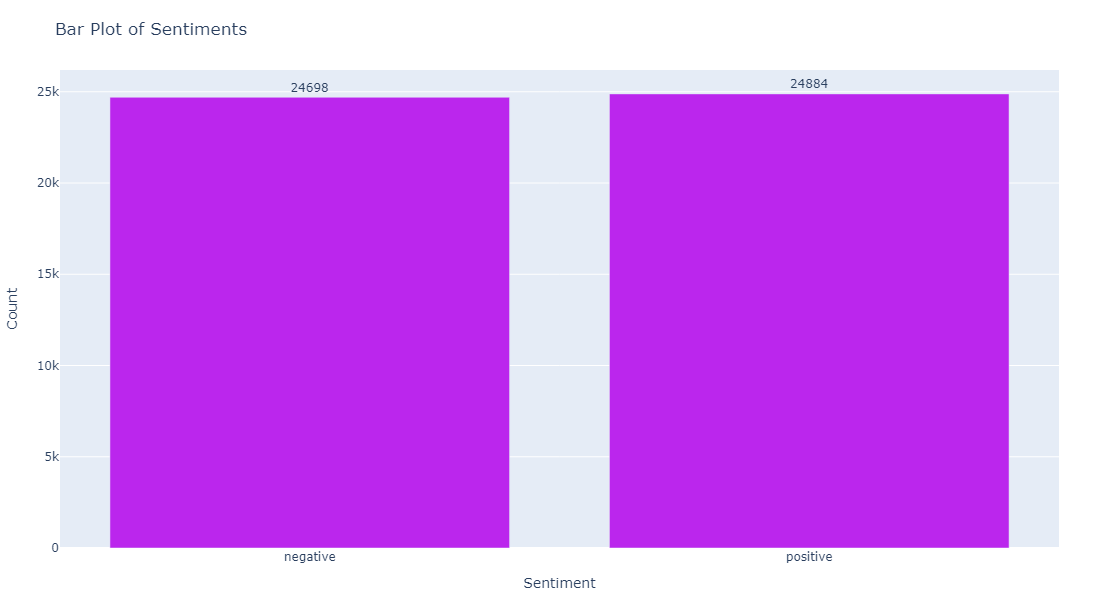

In [18]:
# Create the bar plot
fig = go.Figure()

# Add bars to the plot
fig.add_trace(go.Bar(x=sentiment_counts.index,y=sentiment_counts.values,text=sentiment_counts.values,
                     textposition='outside',marker=dict(color='#bb26ed'),name='Sentiment'))

# Update layout
fig.update_layout(title='Bar Plot of Sentiments',xaxis_title='Sentiment',yaxis_title='Count',
    margin=dict(l=40, r=40, t=70, b=40),height=600,width=800)

# Show the plot
fig.show()

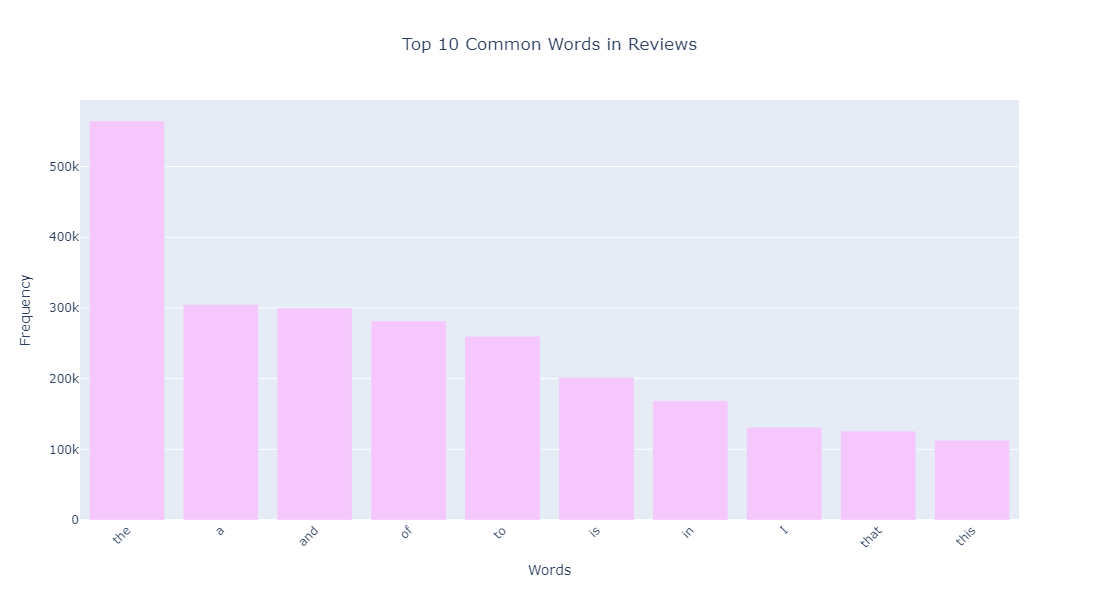

In [19]:
from collections import Counter
all_reviews = ' '.join(df['review'])
# Tokenize the reviews into words
words = all_reviews.split()
word_counts = Counter(words).most_common(10)
common_words = word_counts  
words, counts = zip(*common_words)

# Create a bar chart using Plotly
fig = go.Figure([go.Bar(x=words, y=counts, marker_color='#f5c7fc')])

# Customize the chart layout
fig.update_layout(title="Top 10 Common Words in Reviews",xaxis_title="Words",yaxis_title="Frequency"
                  ,xaxis=dict(tickangle=-45),title_x=0.5,height=600,width=800)

# Display the bar chart
fig.show()

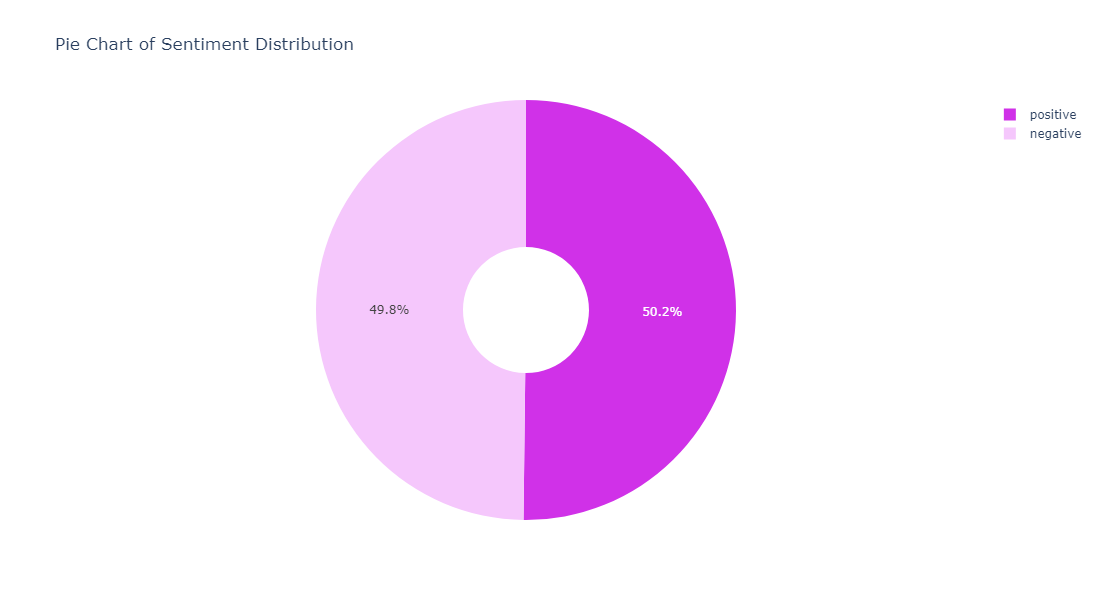

In [20]:
# Create a pie chart
fig = px.pie(sentiment_counts, names=sentiment_counts.index, values=sentiment_counts.values,
             title='Pie Chart of Sentiment Distribution', hole=0.3,color_discrete_sequence=['#d031e8', '#f5c7fc'])

# Increase the size of the figure
fig.update_layout(width=800, height=600)  

# Show the plot
fig.show()

In [21]:
#Taking 10 random samples from the dataset
df.sample(10)

review sentiment
18924  'Cry Freedom' is a movie about how far people ...  positive
30158  Going into this movie, I was a bit cautious. I...  positive
5780   when fellini committed 8 1/2 to film many comm...  positive
18440  I f you thought Sam Mendes' first film, the mu...  positive
28233  The scintillating Elizabeth Taylor stars in th...  positive
33185  Here is what happened:<br /><br />1) Head of B...  negative
13452  Zombi 3 starts as a group of heavily armed men...  negative
17168  Burt Kennedy both wrote & directed this wester...  positive
12994  The supposed writer and director Mr.Dhawan has...  negative
17974  When my wife and I decided to watch this movie...  negative

In [22]:
blob=TextBlob(df['review'][3416])
blob.sentiment

Sentiment(polarity=0.42023809523809524, subjectivity=0.5571428571428572)

In [23]:
blob=TextBlob(df['review'][41119])
blob.sentiment

Sentiment(polarity=-0.014285714285714289, subjectivity=0.3965367965367966)

### Insights
- The review 3416 is a positive review as it has a polarity of 0.4. Although the polarity is not above 0.5, it still indicates a positive sentiment.
- The review 41119 is a negative review as it contain negative polarity of -0.014.

###  <span style='color:#bb26ed; font-weight:600;'>Text Preprocessing</span>

In [24]:
# lowercasing the columns
def lowercase_cols(text):
    return text.lower()

df['review']=df['review'].apply(lowercase_cols)

In [25]:
def remove_html_tags_urls_digits(text):
    # Remove HTML tags
    text = re.sub('<.*?>', '', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
     # Remove urls
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  
    return text
    
df['review'] = df['review'].apply(remove_html_tags_urls_digits)

In [26]:
exclude=string.punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', exclude)
    return text.translate(translator)

df['review'] = df['review'].apply(remove_punctuation)

In [27]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    #tokenise words
    words=word_tokenize(text)
    # Remove stopwords and join words back into a single string
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)
df['review'] = df['review'].apply(remove_stopwords)

In [28]:
wnl=WordNetLemmatizer()
def lemmatize_words(text):
    words = word_tokenize(text)
    filtered_words=[wnl.lemmatize(word) for word in words]
    return ' '.join(filtered_words)
    
df['review'] = df['review'].apply(lemmatize_words)

In [29]:
# Coping the original df in to clean dataframe
clean_df=df.copy()
clean_df.head()

review sentiment
0  one reviewer mentioned watching oz episode you...  positive
1  wonderful little production filming technique ...  positive
2  thought wonderful way spend time hot summer we...  positive
3  basically there family little boy jake think t...  negative
4  petter matteis love time money visually stunni...  positive

In [30]:
print(df['review'][1])

wonderful little production filming technique unassuming oldtimebbc fashion give comforting sometimes discomforting sense realism entire piece actor extremely well chosen michael sheen got polari voice pat truly see seamless editing guided reference williams diary entry well worth watching terrificly written performed piece masterful production one great master comedy life realism really come home little thing fantasy guard rather use traditional dream technique remains solid disappears play knowledge sens particularly scene concerning orton halliwell set particularly flat halliwells mural decorating every surface terribly well done


##### The html tags have been removed and the text is preprocessed ,ready to be converted in to vector form.

In [31]:
positive_reviews=' '.join(df[df['sentiment']=='positive']['review'])
negative_reviews=' '.join(df[df['sentiment']=='negative']['review'])

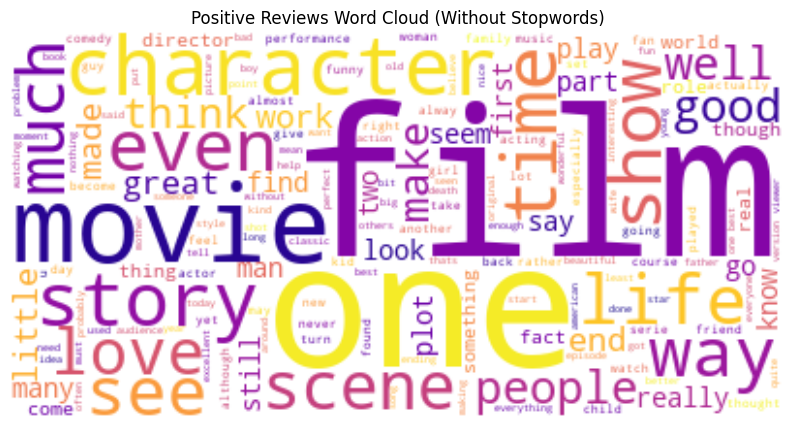

In [32]:
plt.figure(figsize=(10,8))
my_pos_review=WordCloud(background_color='white',colormap='plasma').generate(positive_reviews)
plt.imshow(my_pos_review,interpolation='bilinear')
plt.title('Positive Reviews Word Cloud (Without Stopwords)')
plt.axis('off')
plt.show()

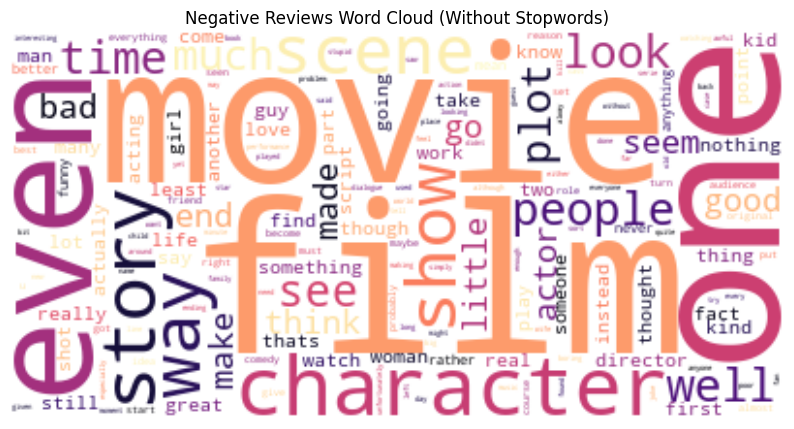

In [33]:
plt.figure(figsize=(10,8))
my_neg_review=WordCloud(background_color='white',colormap='magma').generate(negative_reviews)
plt.imshow(my_neg_review,interpolation='bilinear')
plt.title('Negative Reviews Word Cloud (Without Stopwords)')
plt.axis('off')
plt.show()

In [34]:
stop_words.update(['movie', 'film', 'cinema','films','character','characters']) 

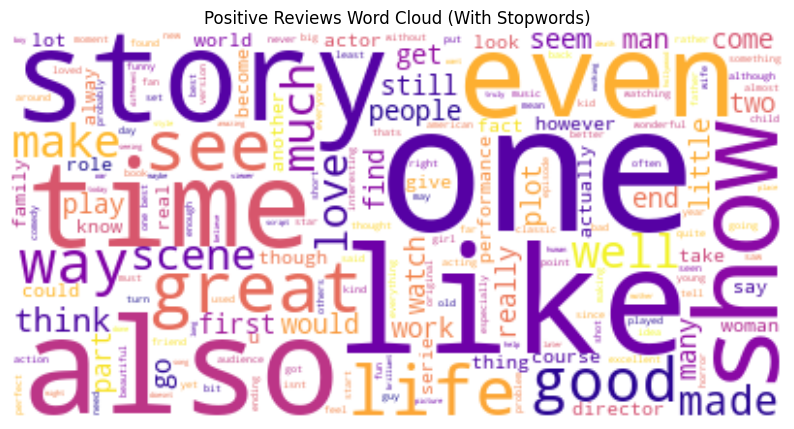

In [35]:
plt.figure(figsize=(10,8))
my_pos_review=WordCloud(background_color='white',stopwords=stop_words,colormap='plasma').generate(positive_reviews)
plt.imshow(my_pos_review,interpolation='bilinear')
plt.title('Positive Reviews Word Cloud (With Stopwords)')
plt.axis('off')
plt.show()

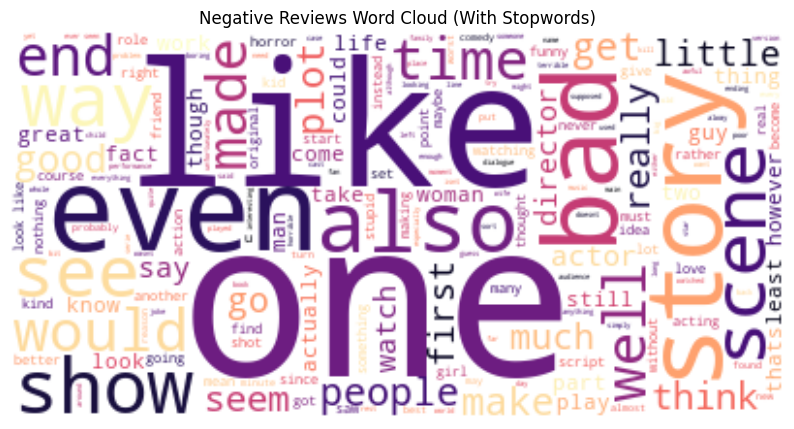

In [36]:
plt.figure(figsize=(10,8))
my_neg_review=WordCloud(background_color='white',stopwords=stop_words,colormap='magma').generate(negative_reviews)
plt.imshow(my_neg_review,interpolation='bilinear')
plt.title('Negative Reviews Word Cloud (With Stopwords)')
plt.axis('off')
plt.show()

In [37]:
# tranforming the target feature in to digit format 
le=LabelEncoder()
clean_df['sentiment']=le.fit_transform(clean_df['sentiment'])
clean_df['sentiment']

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 49582, dtype: int32

In [38]:
clean_df.head()

review  sentiment
0  one reviewer mentioned watching oz episode you...          1
1  wonderful little production filming technique ...          1
2  thought wonderful way spend time hot summer we...          1
3  basically there family little boy jake think t...          0
4  petter matteis love time money visually stunni...          1

In [39]:
# Seperating the input and target features
X = clean_df['review']
y = clean_df['sentiment']

In [40]:
print(f'shape of input features {X.shape}')
print(f'shape of target features {y.shape}')

shape of input features (49582,)
shape of target features (49582,)


In [41]:
# Converting the review in to vector form
tfidf=TfidfVectorizer()
X=tfidf.fit_transform(clean_df['review'])

In [42]:
#splitting the dataset in to train set and test set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

In [43]:
print(f'shape of X train {X_train.shape}')
print(f'shape of y train {y_train.shape}')

shape of X train (34707, 203300)
shape of y train (34707,)


### <span style='color:#bb26ed; font-weight:600;'>Naive Bayes</span>

In [44]:
# Instantiaing a naive bayes object
nb = MultinomialNB()
# fit it on to the training data
nb.fit(X_train, y_train)

MultinomialNB()

In [45]:
#making prediction on to the test data 
nb_pred = nb.predict(X_test)
#Generating classification report
report=classification_report(y_test, nb_pred)
print(f'Naive Bayes Classification Report: \n{report}')

Naive Bayes Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      7410
           1       0.87      0.85      0.86      7465

    accuracy                           0.86     14875
   macro avg       0.86      0.86      0.86     14875
weighted avg       0.86      0.86      0.86     14875



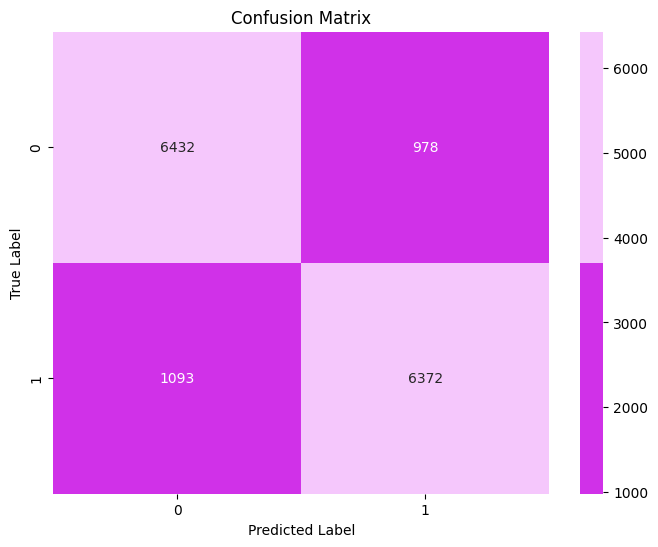

In [46]:
matrix=confusion_matrix(y_test,nb_pred)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap=['#d031e8','#f5c7fc'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [47]:
# Save Naive Bayes model
with open('naive_bayes_model.pkl', 'wb') as nb_file:
    pickle.dump(nb, nb_file)
print('Mode Saved Successfully')

Mode Saved Successfully


### <span style='color:#bb26ed; font-weight:600;'>Logisitic Regression</span>

In [48]:
# Instantiaing a logistic regression object
lor = LogisticRegression(max_iter=1000)
# fit it on to the training data
lor.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [49]:
#making prediction on to the test data 
lor_pred = lor.predict(X_test)
#Generating classification report
report=classification_report(y_test, lor_pred)
print(f'Logistic Regression Classification Report: \n{report}')

Logistic Regression Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      7410
           1       0.88      0.91      0.89      7465

    accuracy                           0.89     14875
   macro avg       0.89      0.89      0.89     14875
weighted avg       0.89      0.89      0.89     14875



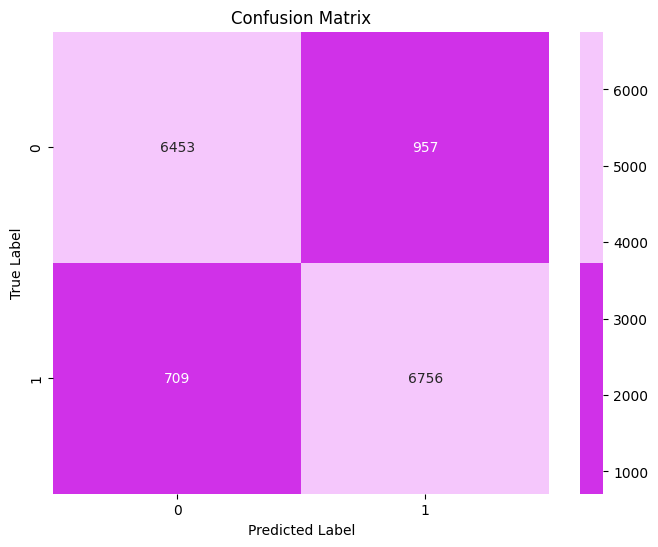

In [50]:
matrix=confusion_matrix(y_test,lor_pred)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap=['#d031e8','#f5c7fc'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [51]:
# Save Logistic Regression model
with open('logistic_regression_model.pkl', 'wb') as lor_file:
    pickle.dump(lor, lor_file)
print('Mode Saved Successfully')

Mode Saved Successfully


### <span style='color:#bb26ed; font-weight:600;'>Random Forest</span>

In [52]:
# Instantiaing a random forest object
rf = RandomForestClassifier(class_weight='balanced')
# fit it on to the training data
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [53]:
#making prediction on to the test data 
rf_pred = rf.predict(X_test)
#Generating classification report
report=classification_report(y_test, rf_pred)
print(f'Random Forest Classification Report: \n{report}')

Random Forest Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      7410
           1       0.85      0.85      0.85      7465

    accuracy                           0.85     14875
   macro avg       0.85      0.85      0.85     14875
weighted avg       0.85      0.85      0.85     14875



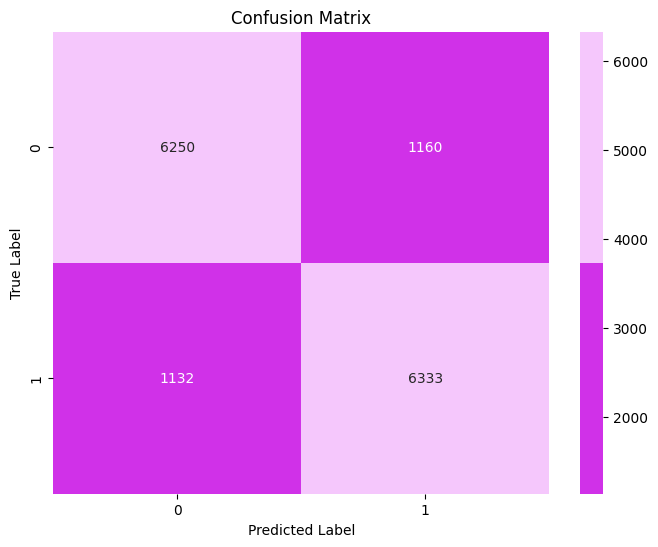

In [54]:
matrix=confusion_matrix(y_test,rf_pred)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap=['#d031e8','#f5c7fc'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [55]:
# Save RandomForest model
with open('random_forest_model.pkl', 'wb') as rf_file:
    pickle.dump(rf, rf_file)
print('Mode Saved Successfully')

Mode Saved Successfully


In [56]:
# Save the vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf, vectorizer_file)
print('Vectorizer Saved Successfully')

Vectorizer Saved Successfully
